In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, TensorDataset, DataLoader
import math
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.cluster import KMeans
import os
import random

c:\Foranac\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Импорт кастомных методов

In [2]:
from data.data_generation import runge_kutta, lorentz_ode
from data.data_preparation import generate_generalized_z_vectors, grid_search_patterns_fixed, get_batches_from_dataloaders, make_dataset, generate_last_inputs, grid_search_patterns_mult, make_dataset_mult

from models_unpred.train import train_one_step, train_mult_step

from models_unpred.model_one_step import SiameseLSTMWithAttention
from models_unpred.model_seq2seq import MultiStepSiameseLSTM

from models_unpred.unpredictable_one_step import predict_multi_step, robust_multi_step_predict, predict_and_analyze

### Создание обучающей выборки

In [39]:
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    np.random.seed(SEED)
    random.seed(SEED)

In [27]:
time_steps = np.arange(0, 1500, 0.1)
params = {'σ' : 10., 'ρ' : 28., 'β' : 8/3}
xyz0 = np.array([1., 1., 1.])
lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
x, y, z = lorenz_solution[2000:].T

In [33]:
train, test = x[:12000],x[12000:]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Эксперименты

#### One-step model

In [ ]:
batch_sizes = [128, 256]
embedding_dims = [5]
max_lags = [3,2,1]
hidden_sizes = [64,128]
num_epochs_list = [5,5,3,2]  #10,12,15 эпох

results = []
lst = list(product(
    batch_sizes, embedding_dims, max_lags, hidden_sizes))

for batch_size, embedding_dim, max_lag, hidden_size in tqdm(lst):

    train_res, test_res, train_batches, val_batches = make_dataset(
        train_scaled, test_scaled, 
        batch_size=batch_size,
        embedding_dim=embedding_dim,
        max_lag=max_lag
    )
    
    patterns = [p for p, _, _ in train_res]
    max_offset = max(sum(p) for p in patterns)

    input_size = 1
    num_patterns = len(train_res)
    model = SiameseLSTMWithAttention(
        input_size=input_size,
        hidden_size=hidden_size,
        num_patterns=num_patterns
    )
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    nn_epoch = 0
    for num_epochs in num_epochs_list:
        nn_epoch += num_epochs
        trained_model = train_one_step(
            model, criterion, optimizer, 
            train_batches, val_batches,
            num_epochs=num_epochs
        )
        
        h = [1,5,20,50,100,200]
        for steps in h:
            input_values = test_scaled[:max_offset]
            true_values = test_scaled[max_offset:max_offset+steps]
            predictions_forced = predict_multi_step(
                                    trained_model,
                                    input_values,
                                    patterns,
                                    steps=steps)
            
            results_var = robust_multi_step_predict(trained_model,
                        input_values,
                        patterns,
                        steps=steps,
                        variance_threshold=0.01, replacement_strategy="last")
            
            results_mc = predict_and_analyze(
                        model=trained_model,
                        initial_series=input_values,
                        patterns=patterns,
                        steps=steps,  
                        n_mc=10,   
                        degenerate_threshold=1e-4,
                        cluster_variance_threshold=0.01
                    )

            mse_forced = mean_squared_error(predictions_forced, true_values)
            rmse_forced = root_mean_squared_error(predictions_forced, true_values)
            mape_forced = mean_absolute_percentage_error(predictions_forced, true_values)

            mse_var= mean_squared_error(np.where(results_var['unpredictable_flags'], 0, results_var['corrected_predictions']), np.where(results_var['unpredictable_flags'], 0, true_values))
            rmse_var = root_mean_squared_error(np.where(results_var['unpredictable_flags'], 0, results_var['corrected_predictions']), np.where(results_var['unpredictable_flags'], 0, true_values))
            mape_var = mean_absolute_percentage_error(np.where(results_var['unpredictable_flags'], 0, results_var['corrected_predictions']), np.where(results_var['unpredictable_flags'], 0, true_values))

            non_pred_share_var = sum(results_var['unpredictable_flags'])/steps

            mse_mc= mean_squared_error(np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions']), np.where(results_mc['unpredictable_flags'], 0, true_values))
            rmse_mc = root_mean_squared_error(np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions']), np.where(results_mc['unpredictable_flags'], 0, true_values))
            mape_mc = mean_absolute_percentage_error(np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions']), np.where(results_mc['unpredictable_flags'], 0, true_values))

            non_pred_share_mc = sum(results_mc['unpredictable_flags'])/steps

            results.append({
                'batch_size': batch_size,
                'embedding_dim': embedding_dim,
                'max_lag': max_lag,
                'hidden_size': hidden_size,
                'num_epochs': nn_epoch,
                'h':steps,
                'mse_forced': mse_forced,
                'rmse_forced': rmse_forced,
                'mape_forced': mape_forced,
                'mse_var': mse_var,
                'rmse_var': rmse_var,
                'mape_var': mape_var,
                'mse_mc': mse_mc,
                'rmse_mc': rmse_mc,
                'mape_mc': mape_mc,
                'non_pred_share_var':non_pred_share_var,
                'non_pred_share_mc':non_pred_share_mc})
            
        print(f"Completed: {batch_size}, {embedding_dim}, {max_lag}, {hidden_size}, {nn_epoch}")
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'experiment_results_long_{batch_size}_{embedding_dim}_{max_lag}_{hidden_size}_{nn_epoch}.csv', index=False)

results_df = pd.DataFrame(results)
results_df.to_csv('experiment_results_long.csv', index=False)
print("Results saved")

#### Seq2Seq model

In [ ]:
batch_sizes = [128, 256]
embedding_dims = [9]
max_lags = [3,2,1]
hidden_sizes = [64,128]
ns = [4]
num_epochs_list = [5,5,5,5,5] 

results = []
lst = list(product(
    batch_sizes, embedding_dims, max_lags, hidden_sizes, ns))

for batch_size, embedding_dim, max_lag, hidden_size, n in tqdm(lst):

    train_res, test_res, train_batches, val_batches = make_dataset_mult(
        train_scaled, test_scaled,
        batch_size=batch_size,
        embedding_dim=embedding_dim,
        max_lag=max_lag,
        n = n
    )

    patterns = [p for p, _, _ in train_res]
    max_offset = max(sum(p) for p in patterns)

    input_size = 1
    num_patterns = len(train_res)
    model = MultiStepSiameseLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_patterns=len(train_res),
            n_steps=n+1
        ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

    nn_epoch = 0
    for num_epochs in num_epochs_list:
        nn_epoch += num_epochs

        trained_model = train_mult_step(model, criterion, optimizer, train_batches,val_batches, num_epochs = num_epochs)

        h = [1,5,20,50,100,200]
        for steps in h:
            input_values = test_scaled[:max_offset]
            true_values = test_scaled[max_offset:max_offset+steps]
            predictions_forced = trained_model.simple_multi_step_predict(
                                    input_values,
                                    patterns,
                                    steps=steps)

            results_var = trained_model.robust_multi_step_predict(
                        initial_series=input_values,
                        patterns=patterns,
                        steps = steps,
                        variance_threshold=0.01, replacement_strategy="last")

            results_mc = trained_model.predict_multi_step_with_analysis(
                        initial_series=input_values,
                        patterns=patterns,
                        steps=steps, 
                        n_mc=10,   
                        degenerate_threshold=1e-4,
                        cluster_variance_threshold=0.01
                    )

            mse_forced = mean_squared_error(predictions_forced, true_values)
            rmse_forced = root_mean_squared_error(predictions_forced, true_values)
            mape_forced = mean_absolute_percentage_error(predictions_forced, true_values)

            mse_var= mean_squared_error(np.where(results_var['unpredictable_flags'], 0, results_var['corrected_predictions']), np.where(results_var['unpredictable_flags'], 0, true_values))
            rmse_var = root_mean_squared_error(np.where(results_var['unpredictable_flags'], 0, results_var['corrected_predictions']), np.where(results_var['unpredictable_flags'], 0, true_values))
            mape_var = mean_absolute_percentage_error(np.where(results_var['unpredictable_flags'], 0, results_var['corrected_predictions']), np.where(results_var['unpredictable_flags'], 0, true_values))

            non_pred_share_var = sum(results_var['unpredictable_flags'])/steps

            mse_mc= mean_squared_error(np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions']), np.where(results_mc['unpredictable_flags'], 0, true_values))
            rmse_mc = root_mean_squared_error(np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions']), np.where(results_mc['unpredictable_flags'], 0, true_values))
            mape_mc = mean_absolute_percentage_error(np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions']), np.where(results_mc['unpredictable_flags'], 0, true_values))

            non_pred_share_mc = sum(results_mc['unpredictable_flags'])/steps

            results.append({
                'batch_size': batch_size,
                'embedding_dim': embedding_dim,
                'max_lag': max_lag,
                'hidden_size': hidden_size,
                'num_epochs': nn_epoch,
                'h':steps,
                'mse_forced': mse_forced,
                'rmse_forced': rmse_forced,
                'mape_forced': mape_forced,
                'mse_var': mse_var,
                'rmse_var': rmse_var,
                'mape_var': mape_var,
                'mse_mc': mse_mc,
                'rmse_mc': rmse_mc,
                'mape_mc': mape_mc,
                'non_pred_share_var':non_pred_share_var,
                'non_pred_share_mc':non_pred_share_mc})

        print(f"Completed: {batch_size}, {embedding_dim}, {max_lag}, {hidden_size}, {nn_epoch}")
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'experiment_results_mult_long_{batch_size}_{embedding_dim}_{max_lag}_{hidden_size}_{nn_epoch}.csv', index=False)

results_df = pd.DataFrame(results)
results_df.to_csv('experiment_results_mult_long.csv', index=False)
print("Results saved")

# Одна модель

#### One-step

In [40]:
train_results, test_results, train_batches, val_batches = make_dataset(train_scaled, test_scaled, seed_worker, batch_size = 128, embedding_dim = 5, max_lag = 3)

input_size = 1
hidden_size = 128
num_patterns = len(train_results)

model = SiameseLSTMWithAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_patterns=num_patterns
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model_1 = train_one_step(model, criterion, optimizer, train_batches, val_batches, num_epochs = 13)

In [ ]:
patterns = [p for p, _, _ in train_results]
max_offset = max(sum(p) for p in patterns)
steps = 200
input_values = test_scaled[:max_offset]
predictions_forced = predict_multi_step(
                                    model_1,
                                    input_values,
                                    patterns,
                                    steps=steps)
            
results_var = robust_multi_step_predict(model_1,
            input_values,
            patterns,
            steps=steps,
            variance_threshold=0.01, replacement_strategy="last")

results_mc = predict_and_analyze(
            model=model_1,
            initial_series=input_values,
            patterns=patterns,
            steps=steps,  
            n_mc=10,   
            degenerate_threshold=1e-4,
            cluster_variance_threshold=0.01
        )

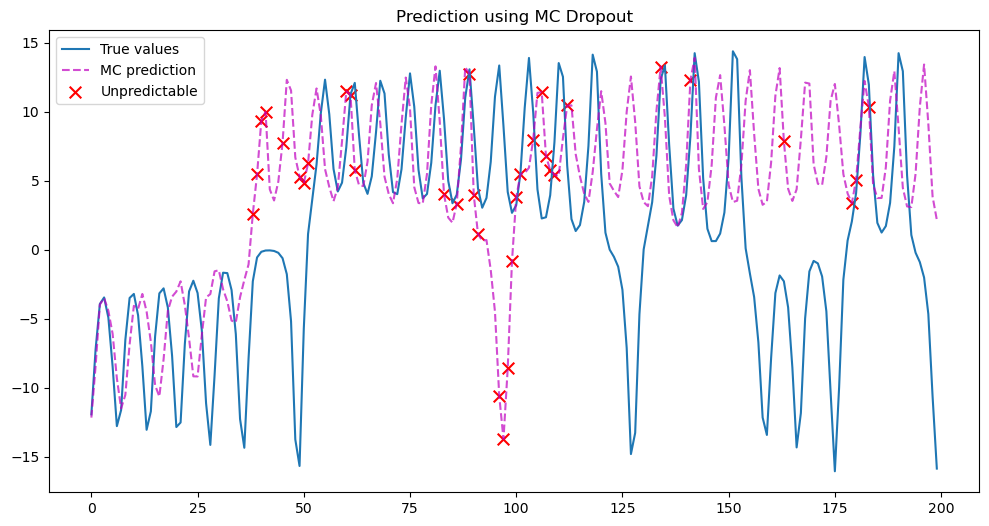

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(test[max_offset:max_offset+200], label = 'True values')
plt.plot(scaler.inverse_transform(predictions_forced.reshape(-1,1)), 'm--', alpha=0.7, label='MC prediction')
plt.scatter(
    results_mc['unpredictable_indices'],
    scaler.inverse_transform(predictions_forced[results_mc['unpredictable_indices'].reshape(-1,1)]),
    color='red', marker='x', s=70, label='Unpredictable'
)
n_unpred = np.cumsum([results_mc['unpredictable_indices']])
plt.title("Prediction using MC Dropout")
plt.legend()
plt.show()

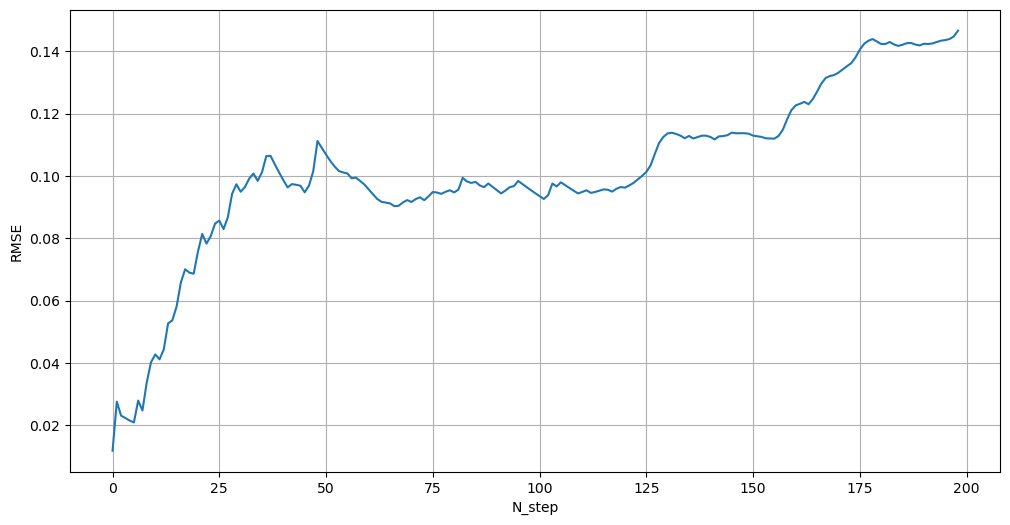

In [52]:
plt.figure(figsize=(12, 6))
mc_pred = np.where(results_mc['unpredictable_flags'], 0, results_mc['corrected_predictions'])
true = np.where(results_mc['unpredictable_flags'], 0, test_scaled[max_offset:max_offset+200])
rmse = [root_mean_squared_error([mc_pred[:i]], [true[:i]]) for i in range(1,len(mc_pred))]
plt.plot(rmse)
plt.xlabel("N_step")
plt.ylabel("RMSE")
plt.grid()
plt.show()

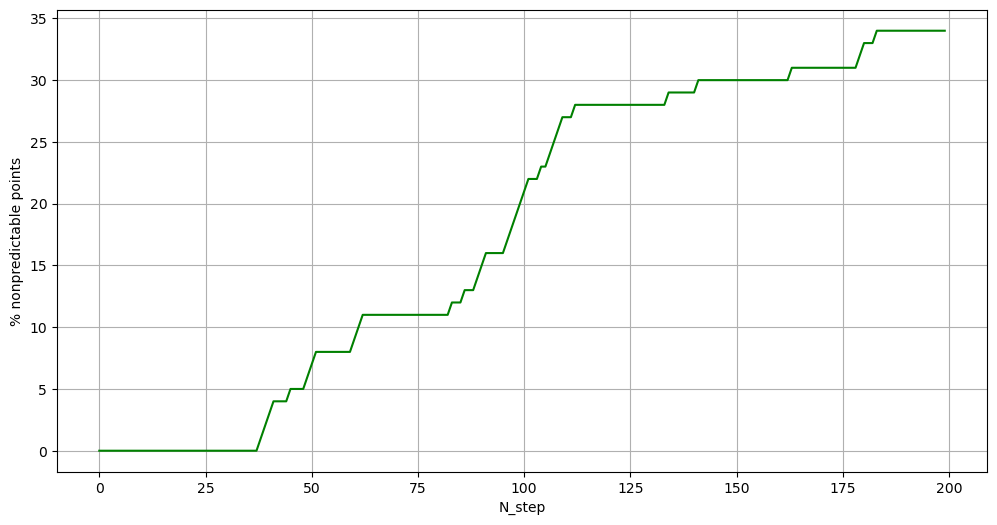

In [53]:
plt.figure(figsize=(12, 6))
n_unpred = np.cumsum([results_mc['unpredictable_flags']])
plt.plot(n_unpred, color = 'green')
plt.xlabel("N_step")
plt.ylabel("% nonpredictable points")
plt.grid()
plt.show()

#### Seq2Seq

In [27]:
n = 4
train_results, test_results, train_batches, val_batches = make_dataset_mult(train_scaled, test_scaled, seed_worker, batch_size = 128, embedding_dim = 9, max_lag = 3, n=n)

input_size = 1
hidden_size = 128
num_patterns = len(train_results)

model = MultiStepSiameseLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_patterns=len(train_results),
    n_steps=5
).to(device)

num_epochs = 1
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_batches[0]),
    epochs=num_epochs
)

model_1 = train_mult_step(model, criterion, optimizer,train_batches,val_batches, teacher_forcing_ratio=0.7, num_epochs = 1)